# MNIST 手寫數字辨識資料集介紹 & 多層感知器模型(MLP)

![MLP](http://cntk.ai/jup/cntk103c_MNIST_MLP.png)

圖片出處:[CNTK_103C_MNIST_MultiLayerPerceptron](https://cntk.ai/pythondocs/CNTK_103C_MNIST_MultiLayerPerceptron.html)

### STEP1. 匯入 Keras 及相關模組 

首先匯入 Keras 及相關模組: 

In [1]:
import numpy as np
import pandas as pd
from keras.utils import np_utils  # 用來後續將 label 標籤轉為 one-hot-encoding

np.random.seed(10)

Using TensorFlow backend.


### STEP2. 下載 mnist 資料

下載 Mnist 資料 
我們將建立以下 Keras 程式, 下載並讀取 mnist 資料. 

Mnist 資料的下載路徑在 ~/.keras/datasets/mnist.npz (npz is a simple zip archive, which contains numpy files.) 

In [2]:
from keras.datasets import mnist

### STEP3. 讀取與查看 mnist 資料

In [3]:
(X_train_image, y_train_label), (X_test_image, y_test_label) = mnist.load_data()

print("\t[Info] train data={:7,}".format(len(X_train_image)))  
print("\t[Info] test  data={:7,}".format(len(X_test_image))) 

	[Info] train data= 60,000
	[Info] test  data= 10,000


由上可以知道 training data 共有 60,000 筆; testing data 共有 10,000 筆。

## 查看訓練資料

接著我們來看載入資料的長相與格式.

### STEP1. 訓練資料是由 images 與 labels 所組成

In [4]:
print("\t[Info] Shape of train data=%s" % (str(X_train_image.shape)))
print("\t[Info] Shape of train label=%s" % (str(y_train_label.shape)))

	[Info] Shape of train data=(60000, 28, 28)
	[Info] Shape of train label=(60000,)


訓練資料是由 images 與 labels 所組成共有 60,000 筆, 每一筆代表某個數字的影像為 28x28 pixels.

### STEP2. 定應 plot_image 函數顯示數字影像

In [5]:
import matplotlib.pyplot as plt
def plot_image(image):
    fig = plt.gcf()
    fig.set_size_inches(2, 2)
    plt.imshow(image, cmap='binary') # cmap='binary' 參數設定以黑白灰階顯示
    plt.show()

### STEP3. 執行 plot_image 函數查看第 0 筆數字影像與 label 資料 

以下程式呼叫 plot_image 函數, 傳入 X_train_image[0], 也就是順練資料集的第 0 筆資料, 顯示結果可以看到這是一個數字 5 的圖形: 

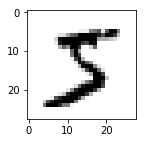

In [6]:
plot_image(X_train_image[0])

In [7]:
y_train_label[0]

5

## 查看多筆訓練資料 images 與 labels

接下來我們將建立 plot_images_labels_predict 函數, 可以顯示多筆資料的影像與 label. 

### STEP1. 建立 plot_images_labels_predict() 函數

因為後續我們希望能很方便查看數字圖形, 真實的數字與預測結果, 所以我們建立了以下函數:

In [8]:
def plot_images_labels_predict(images, labels, prediction, idx, num=10):  
    fig = plt.gcf()  
    fig.set_size_inches(12, 14)  
    if num > 25: num = 25  
    for i in range(0, num):  
        ax=plt.subplot(5,5, 1+i)  
        ax.imshow(images[idx], cmap='binary')  
        title = "l=" + str(labels[idx])  
        if len(prediction) > 0:  
            title = "l={},p={}".format(str(labels[idx]), str(prediction[idx]))  
        else:  
            title = "l={}".format(str(labels[idx]))  
        ax.set_title(title, fontsize=10)  
        ax.set_xticks([]); ax.set_yticks([])  
        idx+=1  
    plt.show()

### STEP2. 查看訓練資料的前 10 筆資料

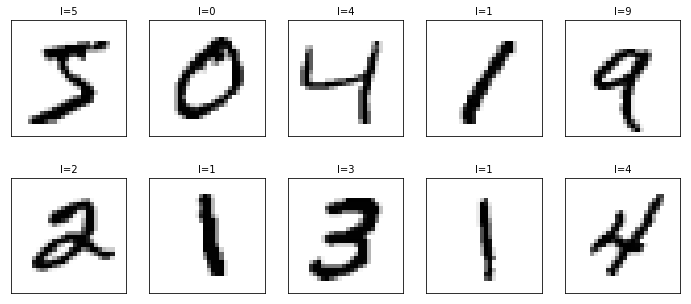

In [9]:
plot_images_labels_predict(X_train_image, y_train_label, [], 0, 10)

## 多層感知器模型資料前處理

接下來我們建立 多層感知器模型 (MLP), 我們必須先將 images 與 labels 的內容進行前處理, 才能餵進去 Keras 預期的資料結構。

### STEP1. features (數字影像的特徵值) 資料前處理

首先將 image 以 reshape 轉換為二維 ndarray 並進行 normalization (Feature scaling): 

In [10]:
x_Train = X_train_image.reshape(60000, 28*28).astype('float32')
x_Test = X_test_image.reshape(10000, 28*28).astype('float32')
print("\t[Info] xTrain: %s" % (str(x_Train.shape)))
print("\t[Info] xTest: %s" % (str(x_Test.shape)))
  
# Normalization
x_Train_norm = x_Train/255
x_Test_norm = x_Test/255

	[Info] xTrain: (60000, 784)
	[Info] xTest: (10000, 784)


### STEP2. labels (影像數字真實的值) 資料前處理

label 標籤欄位原本是 0-9 數字, 而為了配合 Keras 的資料格式, 我們必須進行 One-hot-encoding 將之轉換為 10 個 0 或 1 的組合, 例如數字 7 經過 One-hot encoding 轉換後是 0000001000, 正好對應到輸出層的 10 個神經元. 下面簡單測試過程:

In [11]:
y_TrainOneHot = np_utils.to_categorical(y_train_label) # 將 training 的 label 進行 one-hot encoding
y_TestOneHot = np_utils.to_categorical(y_test_label) # 將測試的 labels 進行 one-hot encoding

y_train_label[0] # 檢視 training labels 第一個 label 的值
y_TrainOneHot[:1] # 檢視第一個 label 在 one-hot encoding 後的結果, 會在第六個位置上為 1, 其他位置上為 0

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]], dtype=float32)

## 建立模型

我們將建立以下多層感知器 Multilayer Perceptron 模型, 輸入層 (x) 共有 28x28=784 個神經元, Hidden layers (h) 共有 256 層; 輸出層 (y) 共有 10 個 神經元:

![mlp](https://3.bp.blogspot.com/-TpTfcbPRWWY/WVW-EUCKVLI/AAAAAAAAWuE/sn9sX6qMc38UePENvSmmgLH3bA7za-3ogCLcBGAs/s1600/3946_3.PNG)

對應代碼:

In [12]:
from keras.models import Sequential  
from keras.layers import Dense  
  
model = Sequential()  # Build Linear Model  
  
model.add(Dense(units=256, input_dim=784, kernel_initializer='normal', activation='relu')) # Add Input/hidden layer  
model.add(Dense(units=10, kernel_initializer='normal', activation='softmax')) # Add Hidden/output layer  
print("\t[Info] Model summary:")  
model.summary()  
print("")

	[Info] Model summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2570      
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
_________________________________________________________________



Summary 的相關說明:

![mlp](https://1.bp.blogspot.com/-XYUDaErijCI/WVW-IliFkOI/AAAAAAAAWuI/g4zOWWWMfpIwIEYWLq2zd0qVJHlRanTHACLcBGAs/s1600/3946_4.PNG)

## 進行訓練

當我們建立深度學習模型後, 就可以使用 Backpropagation 進行訓練。

### STEP1. 定義訓練方式

在訓練模型之前, 我們必須先使用 compile 方法, 對訓練模型進行設定, 代碼如下:

In [13]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

參數說明如下:
* **loss** : 設定 loss function, 在深度學習通常使用 cross_entropy (Cross entropy) 交叉摘順練效果較好.
* **optimizer** : 設定訓練時的優化方法, 在深度學習使用 adam 可以讓訓練更快收斂, 並提高準確率.
* **metrics** : 設定評估模型的方式是 accuracy (準確率)

### STEP2. 開始訓練
執行訓練的程式碼如下:

In [14]:
train_history = model.fit(x=x_Train_norm, 
                          y=y_TrainOneHot, 
                          validation_split=0.2, 
                          epochs=10, 
                          batch_size=200, 
                          verbose=2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
 - 10s - loss: 0.4434 - acc: 0.8813 - val_loss: 0.2193 - val_acc: 0.9400
Epoch 2/10
 - 2s - loss: 0.1916 - acc: 0.9451 - val_loss: 0.1558 - val_acc: 0.9555
Epoch 3/10
 - 2s - loss: 0.1358 - acc: 0.9615 - val_loss: 0.1263 - val_acc: 0.9642
Epoch 4/10
 - 2s - loss: 0.1031 - acc: 0.9705 - val_loss: 0.1126 - val_acc: 0.9675
Epoch 5/10
 - 2s - loss: 0.0813 - acc: 0.9773 - val_loss: 0.0988 - val_acc: 0.9713
Epoch 6/10
 - 2s - loss: 0.0661 - acc: 0.9816 - val_loss: 0.0938 - val_acc: 0.9719
Epoch 7/10
 - 2s - loss: 0.0545 - acc: 0.9849 - val_loss: 0.0912 - val_acc: 0.9739
Epoch 8/10
 - 2s - loss: 0.0457 - acc: 0.9877 - val_loss: 0.0831 - val_acc: 0.9763
Epoch 9/10
 - 2s - loss: 0.0380 - acc: 0.9902 - val_loss: 0.0822 - val_acc: 0.9766
Epoch 10/10
 - 2s - loss: 0.0316 - acc: 0.9919 - val_loss: 0.0802 - val_acc: 0.9769


上面訓練過程會儲存於 train_history 變數中, 參數說明如下: 

* **x = x_Train_norm** : features 數字的影像特徵值 (60,000 x 784 的陣列)
* **y = y_Train_OneHot** : label 數字的 One-hot encoding 陣列 (60,000 x 10 的陣列)
* **validation_split = 0.2** : 設定訓練資料與 cross validation 的資料比率. 也就是說會有 0.8 * 60,000 = 48,000 作為訓練資料; 0.2 * 60,000 = 12,000 作為驗證資料.
* **epochs** = 10 : 執行 10 次的訓練週期.
* **batch_size = 200** : 每一批次的訓練筆數為 200
* **verbose = 2** : 顯示訓練過程. 共執行 10 次 epoch (訓練週期), 每批 200 筆, 也就是每次會有 240 round (48,000 / 200 = 240). 每一次的 epoch 會計算 accuracy 並記錄在 train_history 中.

### STEP3. 建立 show_train_history 顯示訓練過程

之前訓練步驟會將每一個訓練週期的 accuracy 與 loss 記錄在 train_history 變數. 我們可以使用下面程式碼讀取 train_history 以圖表顯示訓練過程:

In [15]:
import matplotlib.pyplot as plt  
def show_train_history(train_history, train, validation):  
    plt.plot(train_history.history[train])  
    plt.plot(train_history.history[validation])  
    plt.title('Train History')  
    plt.ylabel(train)  
    plt.xlabel('Epoch')  
    plt.legend(['train', 'validation'], loc='upper left')  
    plt.show()

執行結果如下:

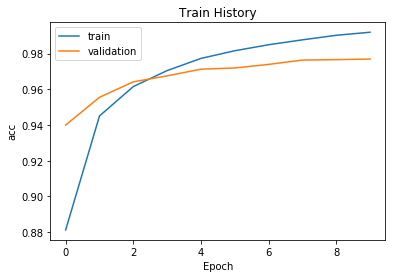

In [16]:
show_train_history(train_history, 'acc', 'val_acc')

如果 "acc 訓練的準確率" 一直提升, 但是 "val_acc 的準確率" 卻一直沒有增加, 就有可能是 Overfitting 的現象 (更多說明請參考 Bias, Variance, and Overfitting). 在完成所有 (epoch) 訓練週期後, 在後面還會使用測試資料來評估模型準確率, 這是另外一組獨立的資料, 所以計算準確率會更客觀. 接著我們來看 loss 誤差的執行結果: 

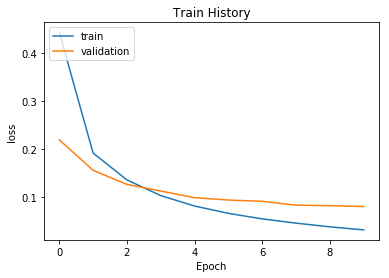

In [17]:
show_train_history(train_history, 'loss', 'val_loss')

總共執行 10 個 Epoch 訓練週期, 可以發現:    
* 不論訓練與驗證, 誤差越來越低.
* 在 Epoch 訓練後期, "loss 訓練的誤差" 比 "val_loss 驗證的誤差" 小.

## 以測試資料評估模型準確率與預測 

我們已經完成訓練模型, 現在要使用 test 測試資料來評估模型準確率。

### STEP1. 評估模型準確率

使用下面代碼評估模型準確率:

In [18]:
scores = model.evaluate(x_Test_norm, y_TestOneHot)  
print()  
print("\t[Info] Accuracy of testing data = {:2.1f}%".format(scores[1]*100.0))

10000/10000 [==============================] - 1s 107us/step

	[Info] Accuracy of testing data = 97.7%


### STEP2. 進行預測
前面我們建立模型並於訓練後達成可以接受的 97% 準確率, 接著我們將使用此模型進行預測。

	[Info] Making prediction to x_Test_norm

	[Info] Show 10 prediction result (From 240):
[5 9 8 7 2 3 0 2 4 2]



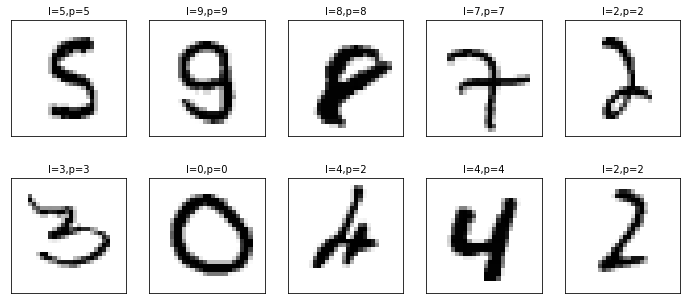

In [19]:
print("\t[Info] Making prediction to x_Test_norm")  
prediction = model.predict_classes(x_Test_norm)  # Making prediction and save result to prediction  
print()  
print("\t[Info] Show 10 prediction result (From 240):")  
print("%s\n" % (prediction[240:250]))  
  
plot_images_labels_predict(X_test_image, y_test_label, prediction, idx=240)

上面可以發現有個預測結果為 6, 但實際 label 為 4. 

## 總結 (Conclusion)

在這篇文章中有一些個人學習到的一些有趣的重點:

* Mnist的手寫資料集雖然很簡單, 但對很多不熟悉把圖像處理的人來說, Mnist絕對是一個合適用來做練習與講解的好資料集
* 需要了解網絡的結構與不同網絡層輸入輸出的張量的結構才能夠清楚地構建一個對的模型

參考:
* [程式扎記 - MNIST 手寫數字辨識資料集介紹](http://puremonkey2010.blogspot.tw/2017/07/toolkit-keras-mnist-cnn.html)
* [林大貴 - TensorFlow+Keras深度學習人工智慧實務應用](http://tensorflowkeras.blogspot.com)